# Cross-Validated LASSO

The goal of this section is to LASSO regression to predict whether an attack will  succeed or fail, given the characteristics of the attack. Our data are categorical one-hot-encoded feature vectors describing the attack, while the labels correspond to the success or failure of the attack. For a discussion of what "success" means in this database, see our main notebook.

## Setup

In [3]:
'''Library imports. sklearn's LassoCV class used for Lasso model'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess_functions import load_data_relevant_cols
from preprocess_functions import get_dummies
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [4]:
# Loading data
raw = load_data_relevant_cols()

/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Feature Selection and One-Hot Encoding

Our database has more than hundred features for each recorded attack. We will concentrate on a few of these for the purposes of this model. Specifically, we will use: 

- attacktype1_txt
- targtype1_txt
- targsubtype1_txt
- weaptype1_txt
- weapsubtype1_txt

Let's examine what the possible values for each of these features are.

In [5]:
# Variable Examples:
print(raw.attacktype1_txt.unique())

['Assassination' 'Hostage Taking (Kidnapping)' 'Bombing/Explosion'
 'Facility/Infrastructure Attack' 'Armed Assault' 'Hijacking' 'Unknown'
 'Unarmed Assault' 'Hostage Taking (Barricade Incident)']


In [6]:
print(raw.targtype1_txt.unique())

['Private Citizens & Property' 'Government (Diplomatic)'
 'Journalists & Media' 'Police' 'Utilities' 'Military'
 'Government (General)' 'Airports & Aircraft' 'Business'
 'Educational Institution' 'Violent Political Party'
 'Religious Figures/Institutions' 'Unknown' 'Transportation' 'Tourists'
 'NGO' 'Telecommunication' 'Food or Water Supply'
 'Terrorists/Non-State Militia' 'Other' 'Maritime' 'Abortion Related']


In [7]:
print(raw.targsubtype1_txt.unique())

['Named Civilian' 'Diplomatic Personnel (outside of embassy, consulate)'
 'Radio Journalist/Staff/Facility' 'Embassy/Consulate'
 'Police Building (headquarters, station, school)'
 'Police Security Forces/Officers' 'Electricity'
 'Military Recruiting Station/Academy'
 'Government Building/Facility/Office'
 'Military Barracks/Base/Headquarters/Checkpost'
 'Aircraft (not at an airport)' 'Retail/Grocery/Bakery' nan
 'Military Personnel (soldiers, troops, officers, forces)'
 'School/University/Educational Building' 'Multinational Corporation'
 'Party Office/Facility' 'House/Apartment/Residence'
 'Race/Ethnicity Identified' 'Judge/Attorney/Court'
 'Police Patrol (including vehicles and convoys)' 'Place of Worship'
 'Vehicles/Transportation' 'Bus (excluding tourists)'
 'Politician or Political Party Movement/Meeting/Rally' 'Hotel/Resort'
 'Airport' 'Bank/Commerce' 'Construction' 'Tour Bus/Van'
 'Train/Train Tracks/Trolley' 'Religion Identified' 'Gas/Oil'
 'Newspaper Journalist/Staff/Facility'

In [8]:
print(raw.weaptype1_txt.unique())

['Unknown' 'Explosives/Bombs/Dynamite' 'Incendiary' 'Firearms' 'Chemical'
 'Fake Weapons' 'Melee' 'Sabotage Equipment'
 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)'
 'Radiological' 'Other' 'Biological']


In [9]:
print(raw.weapsubtype1_txt.unique())

[nan 'Unknown Explosive Type' 'Unknown Gun Type' 'Automatic Weapon'
 'Molotov Cocktail/Petrol Bomb' 'Gasoline or Alcohol'
 'Rifle/Shotgun (non-automatic)' 'Arson/Fire'
 'Projectile (rockets, mortars, RPGs, etc.)' 'Vehicle' 'Dynamite/TNT'
 'Other Explosive Type' 'Pressure Trigger' 'Time Fuse' 'Poisoning'
 'Letter Bomb' 'Handgun' 'Blunt Object' 'Sticky Bomb' 'Grenade'
 'Knife or Other Sharp Object' 'Land Mine' 'Hands, Feet, Fists'
 'Remote Trigger' 'Rope or Other Strangling Device' 'Explosive'
 'Unknown Weapon Type' 'Suffocation'
 'Suicide (carried bodily by human being)' 'Other Gun Type']


To use the categorical variables for analysis, we need to convert them to one-hot-encoded dummy variables, using the Pandas built in get_dummies function.

In [10]:
# Making one-hot-encoded dummy variables
rel_columns = ['attacktype1_txt', 'targtype1_txt', 'targsubtype1_txt', 'weaptype1_txt', 'weapsubtype1_txt']
X = get_dummies(raw, rel_columns)
Y = raw.success

## Model Training

To predict the success or failure of a terrorist attack, we will perform LASSO regression. Formally, LASSO regression learns a set of weights corresponding to each entry of an input vector. When given an input, it uses these weights to compute a linear combination, which is the output. 

Suppose our training data is in the form of a matrix $X$ and vector $\vec{y}$. The rows of $X$ correspond to individual data points, while the entries of $y$ correspond to the labels of the points in $X$. Suppose we have $n$ data points, so that $X \in \mathbb{R}^{n \times d}$ and $y \in \mathbb{R}^{n}$. The goal of LASSO regression is the learn a weight vector $w^{*} \in \mathbb{R}^{d}$ such that 

$$w^{*} = \arg\min_{w \in \mathbb{R}^{d}} \frac{1}{2n}\| Xw - y \|^{2} + \alpha \| w \|_{1}$$

The term $\alpha \| w \|_{1}$ in the objective function is a penalty term for large $w$. Penalizing $w$ with the $\ell_{1}$ norm, as opposed to the $\ell_{2}$ norm used in ridge regression, encourages a sparse solution. This is appropriate given the one-hot encoding of our data, as each input vector will only have a few nonzero entries. 

To determine the optimal $\alpha$, which is a hyperparamter, we will use cross validation with sklearn's pre-build LassoCV class. 

Finally, examining the weights $w$ will tell us which weights are most important.

In [118]:
# LassoCV object and making training and test set
predictor = LassoCV(max_iter=30000, cv=5, alphas=np.logspace(-6, -2, 50), verbose=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
predictor.fit(X_train, y_train)

..........................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished


## Model Evaluation

Now that we've fit the model, we'll examine its hyperparameters and ROC curve. We'll also find the prediction accuracy of the best model.

In [110]:
y_pred = predictor.predict(X_test)

In [111]:
# Using sklearn's roc_curve function
fpr, tpr, thresh = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

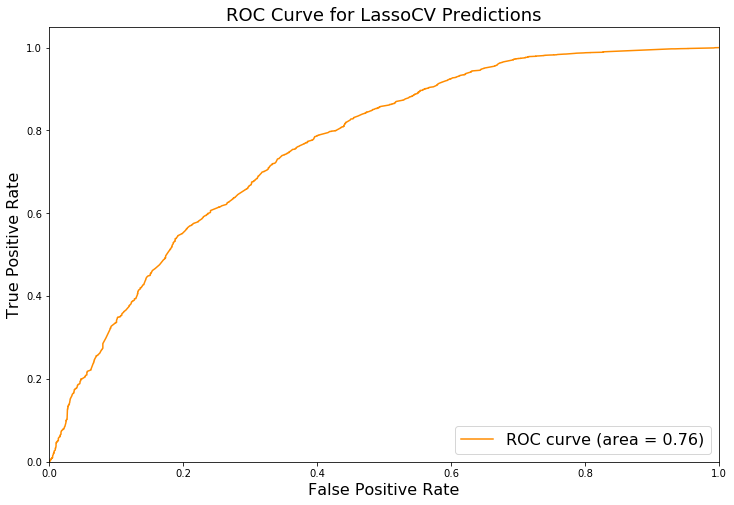

In [112]:
'''We plot the ROC curve and save the image.'''
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve for LassoCV Predictions', fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('figures/lassoROC.png')
plt.show();

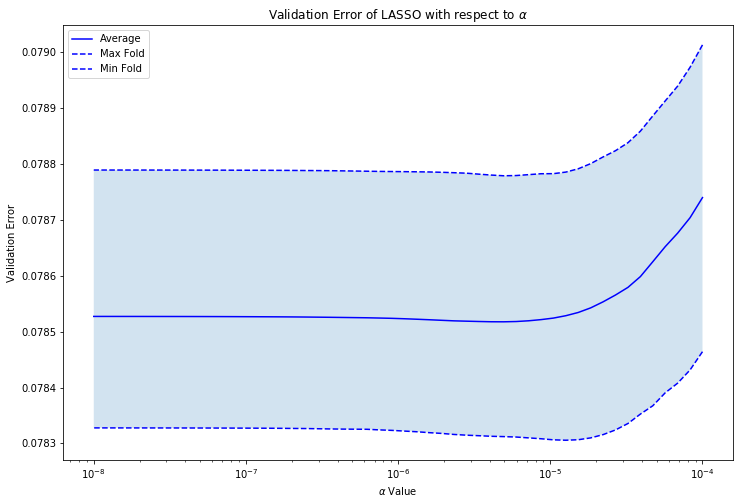

In [117]:
# Find the best alpha 

%matplotlib inline
plt.figure(figsize=(12, 8))
mse_mean = np.mean(predictor.mse_path_, axis=1)
mse_max = np.max(predictor.mse_path_, axis=1)
mse_min = np.min(predictor.mse_path_, axis=1)

# mse_std_dev = np.std(predictor.mse_path_, axis=1)
alphas = predictor.alphas_
plt.plot(alphas, mse_mean, c='blue', label='Average')
plt.plot(alphas, mse_max, 'b--', label='Max Fold')
plt.plot(alphas, mse_min, 'b--', label='Min Fold')
plt.semilogx()
plt.fill_between(alphas, mse_min, mse_max, alpha=0.2)
plt.title(r'Validation Error of LASSO with respect to $\alpha$')
plt.xlabel(r'$\alpha$ Value')
plt.ylabel('Validation Error')
plt.savefig('figures/lasso_cv_alphas_error.png')
plt.legend()
plt.show();

Finally, we examine accuracy and rates of false negatives/positives.

In [114]:
'''We chooose the rounding threshold where the true positive rate 
is greater than 0.9'''
loc = np.min(np.where(tpr > 0.9))
fpr[loc]
threshold = thresh[loc]
# Rounding the predictions based on the threshold
rounded = []
for i in y_pred:
    if i > threshold:
        rounded.append(1)
    else:
        rounded.append(0)
rounded_y_pred = np.array(rounded)

In [115]:
confusion_mat = confusion_matrix(y_test, rounded_y_pred)
true_negative_rate = confusion_mat[0][0]
false_negative_rate = confusion_mat[1][0]
false_positive_rate = confusion_mat[0][1]
true_positive_rate = confusion_mat[1][1]
confusion_mat

array([[  773,   987],
       [ 1535, 13740]])

It appears that LASSO is too conservative in its estimates, since the number of false negatives is substantially larger than the number of positives.

True Negatives: 773

False Negatives: 1535

True Positives: 13740

False Positives: 987

Next, we calculate the raw binary accuracy rate.

In [41]:
num_attacks = true_negative_rate + true_positive_rate + false_positive_rate + false_negative_rate
num_correct = true_negative_rate + true_positive_rate
accuracy = num_correct/num_attacks

In [42]:
accuracy

0.85224537716466098

## Feature Salience

Finally, we examine which features had the highest and lowest weights, to understand what features the model considered most important.

In [81]:
coefficients = pd.DataFrame({'variable':X_train.columns, 'coef':predictor.coef_,})
# Factors that predict for failure

variables_by_coeff = coefficients.sort_values(by='coef', ascending=False)

In [82]:
variables_by_coeff.head(20)

,coef,variable
2,0.127350,attacktype1_txt_Bombing/Explosion
168,0.082603,weapsubtype1_txt_Poisoning
127,0.075595,targsubtype1_txt_Taxi/Rickshaw
170,0.075345,"weapsubtype1_txt_Projectile (rockets, mortars,..."
38,0.072495,targsubtype1_txt_Bus (excluding tourists)
147,0.060172,weaptype1_txt_Melee
64,0.058234,targsubtype1_txt_Intelligence
5,0.049466,attacktype1_txt_Hostage Taking (Barricade Inci...
153,0.049003,weapsubtype1_txt_Arson/Fire
48,0.046772,targsubtype1_txt_Electricity


In [84]:
variables_by_coeff[-20:]

,coef,variable
45,-0.071139,targsubtype1_txt_Diplomatic Personnel (outside...
34,-0.079877,targsubtype1_txt_Airport
113,-0.080517,"targsubtype1_txt_Public Area (garden, parking ..."
8,-0.080592,attacktype1_txt_Unknown
32,-0.084812,targsubtype1_txt_Aircraft (not at an airport)
126,-0.095842,targsubtype1_txt_Subway
166,-0.108390,weapsubtype1_txt_Other Explosive Type
143,-0.128361,weaptype1_txt_Explosives/Bombs/Dynamite
67,-0.137352,targsubtype1_txt_Internet Infrastructure
148,-0.141015,weaptype1_txt_Other


We'll create plots of these values and save them. Note that values with large positive and large negative weights are both *important* - a large positive weight corresponds to success, while a large negative weight corresponds to failure.

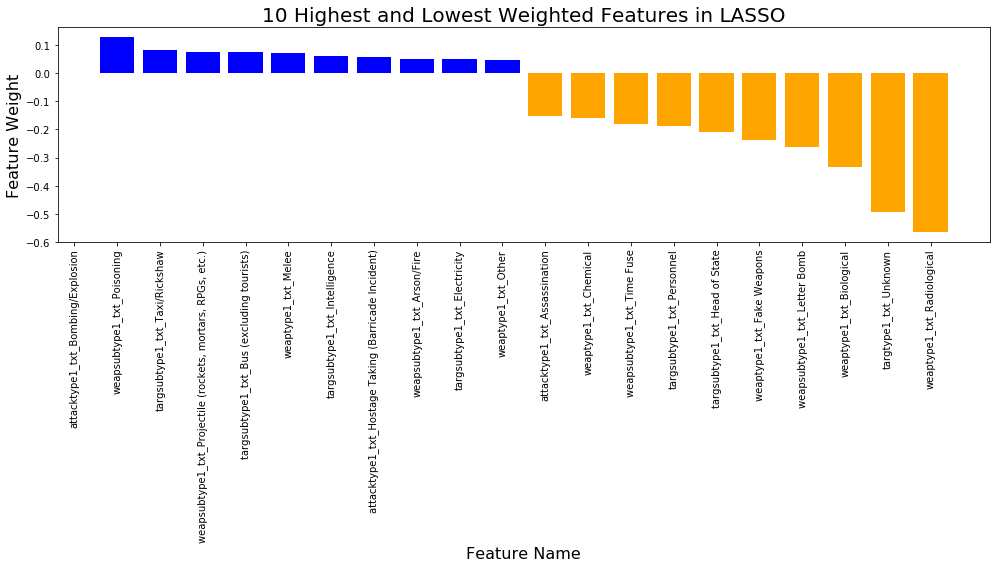

In [104]:
plt.figure(figsize=(14, 8))
coeff_values = list(variables_by_coeff[:10]['coef']) + list(variables_by_coeff[-10:]['coef'])
trait_names = list(variables_by_coeff[:10]['variable']) + list(variables_by_coeff[-11:]['variable'])
plt.bar(np.arange(1, 11), coeff_values[:10], color='blue')
plt.bar(np.arange(11, 21), coeff_values[10:], color='orange')
plt.xticks(range(len(trait_names)), trait_names)
plt.xticks(rotation=90)
plt.title('10 Highest and Lowest Weighted Features in LASSO', fontsize=20)
plt.xlabel('Feature Name', fontsize=16)
plt.ylabel('Feature Weight', fontsize=16)
plt.tight_layout()

In [107]:
np.logspace(-8, -4, 50)

array([  1.00000000e-08,   1.20679264e-08,   1.45634848e-08,
         1.75751062e-08,   2.12095089e-08,   2.55954792e-08,
         3.08884360e-08,   3.72759372e-08,   4.49843267e-08,
         5.42867544e-08,   6.55128557e-08,   7.90604321e-08,
         9.54095476e-08,   1.15139540e-07,   1.38949549e-07,
         1.67683294e-07,   2.02358965e-07,   2.44205309e-07,
         2.94705170e-07,   3.55648031e-07,   4.29193426e-07,
         5.17947468e-07,   6.25055193e-07,   7.54312006e-07,
         9.10298178e-07,   1.09854114e-06,   1.32571137e-06,
         1.59985872e-06,   1.93069773e-06,   2.32995181e-06,
         2.81176870e-06,   3.39322177e-06,   4.09491506e-06,
         4.94171336e-06,   5.96362332e-06,   7.19685673e-06,
         8.68511374e-06,   1.04811313e-05,   1.26485522e-05,
         1.52641797e-05,   1.84206997e-05,   2.22299648e-05,
         2.68269580e-05,   3.23745754e-05,   3.90693994e-05,
         4.71486636e-05,   5.68986603e-05,   6.86648845e-05,
         8.28642773e-05,

## Conclusion

This notebook illustrates both the benefits and limitations of LASSO regression. While the model is easily interpretable based on feature weights, it fails to achieve a 